<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Modify this cell to add your group name, group number and your names and student IDs

Group: 54

Authors: Jeroen Struijk, Rik Maas

In [1]:
import requests
import io
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
dev=torch.device("cuda")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set

For task 1 of Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains 18.800 binary images of handwritten characters of size (28,28). Each of these images depicts one of 893 different characters from 29 different alphabets. Each image is accompanied by a label that is encoded as an interger $y\in\{0, 1, ..., 892\}$ that indicate the caracter depicted in the image. The following cell provides code that loads the data from hardcoded URLs.

You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 


In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
# Downloading may take a while..
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/tvQmLyY7MhVsADb/download')
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/z234AHrQqx9RVGH/download')
print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

train_x shape: (18800, 28, 28)
train_y shape: (18800,)



### Query data set

For this task you need to use the following query data set. The dataset contains 100 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 

Each test set consists of 1 query image and 5 candidate images. All images are the same size (28x28). The test data is organized in two numpy arrays. One for the query images with shape (100, 1, 28, 28) and another for the candidate imagaes with shape (100, 5, 28, 28). 

The task is to develop a model that enables selecting the image which is depicting the same character as the anchor image out of 5 test images. These test images are declared in the `query_x` numpy array . 

Finally, we plot the first 5 cases in the query dataset. The first column corresponds with the anchor images of each of the 5 cases. All other images are test images from which the task is to recognize the anchor image. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the anchor image. 

In [3]:
query_dataset = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/YGn5gb7unBEuCLB/download")
queries_true = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/0sPeeIFB3W9RPZG/download")

queries, candidates_sets = np.split(query_dataset, [1], axis=1)

print(f"query images have shape: {queries.shape}")
print(f"target sets have shape: {candidates_sets.shape}")
print(f"ground truth: {queries_true.shape}")

query images have shape: (100, 1, 28, 28)
target sets have shape: (100, 5, 28, 28)
ground truth: (100,)


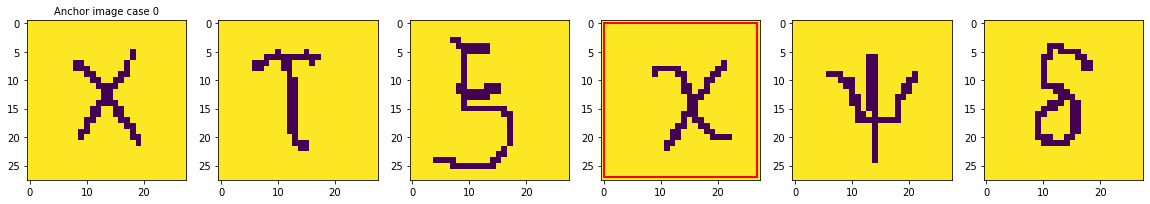

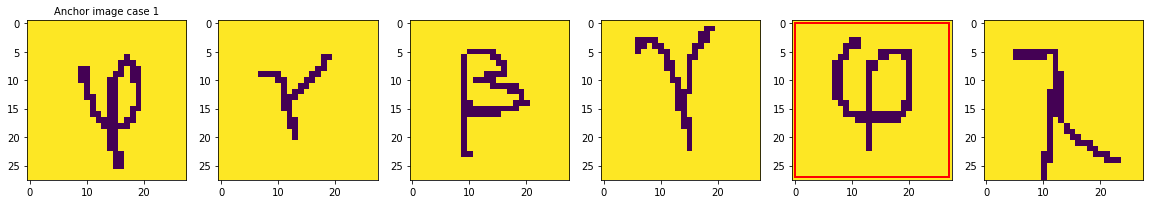

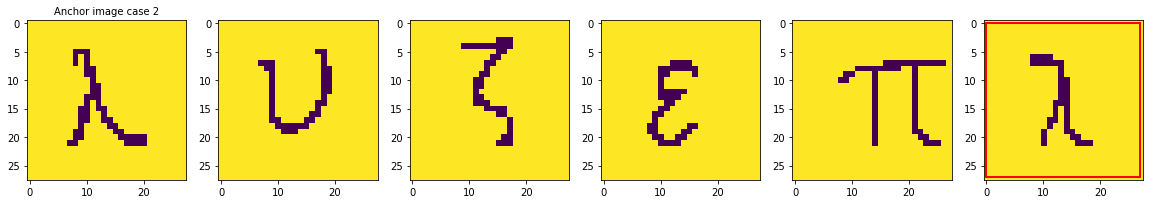

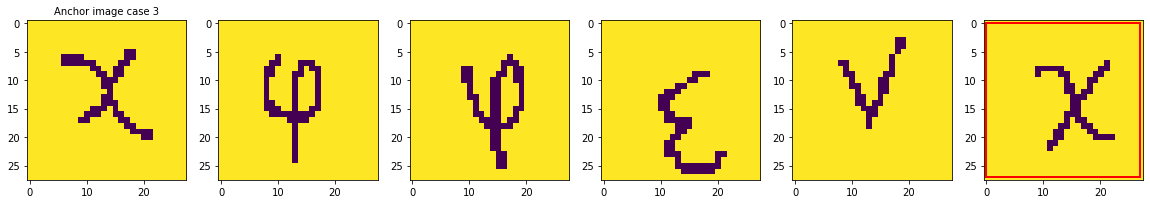

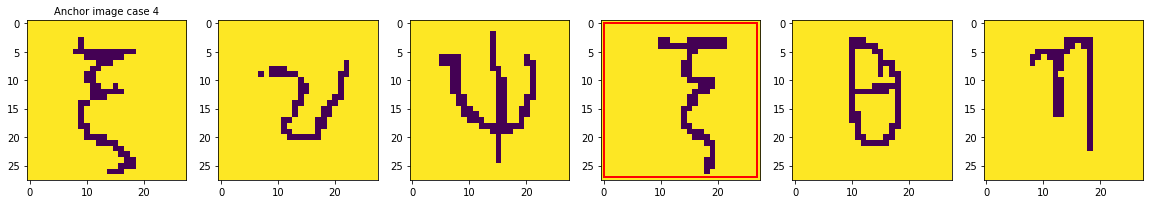

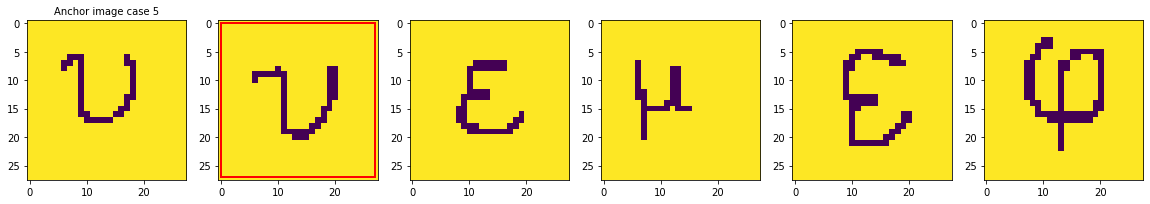

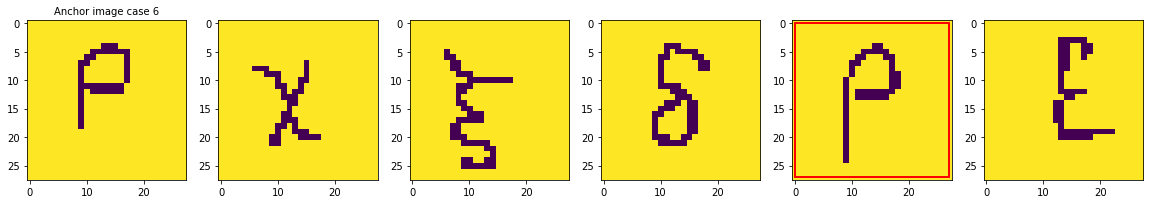

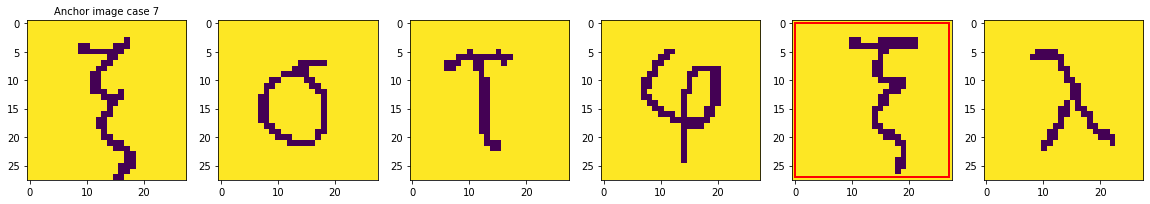

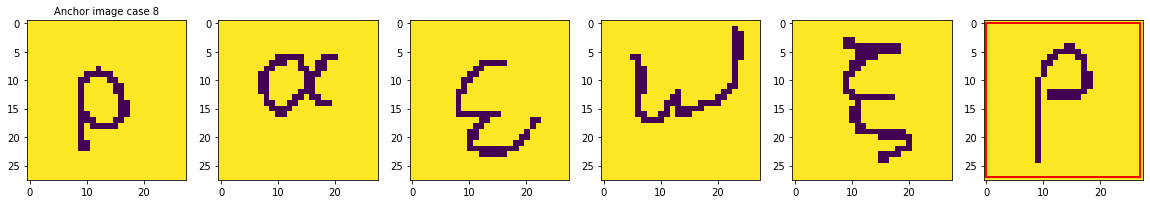

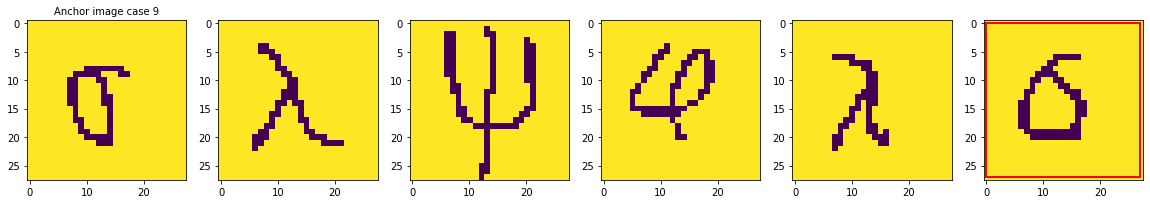

In [4]:
from matplotlib.patches import Rectangle

def plot_case(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    
    
    
    
# plot the first five samples of the query datset
[plot_case(caseID) for caseID in range(10)] ;

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1)

x_train = x_train.reshape(16920, 1, 28, 28)
x_train  = torch.from_numpy(x_train).float()

y_train = y_train.astype(int);
y_train = torch.from_numpy(y_train)

x_val = x_val.reshape(1880, 1, 28, 28)
x_val  = torch.from_numpy(x_val).float()

y_val = y_val.astype(int);
y_val = torch.from_numpy(y_val)



x_train.shape, y_val.shape

(torch.Size([16920, 1, 28, 28]), torch.Size([1880]))

In [56]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(144, 965),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [57]:
##
# TODO: Implement your recognition model here...
# 
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=144, out_features=965, bias=True)
  )
)


In [58]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_tr, y_tr = x_train, y_train
    # getting the validation set
    x_v, y_v = x_val, y_val

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_tr = x_tr.cuda()
        y_tr = y_tr.cuda()
        x_v = x_v.cuda()
        y_v = y_v.cuda()

    
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_tr)
    output_val = model(x_v)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_tr)
    loss_val = criterion(output_val, y_v)
#     train_losses.append(loss_train)
#     val_losses.append(loss_val)

#     # accuracy on training set
#     accuracy_score(train_y, predictions)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
        
    # prediction for training set
    with torch.no_grad():
        output = model(x_tr)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    from sklearn.metrics import accuracy_score
    # accuracy on training set
    print(accuracy_score(y_tr.cpu(), predictions))
    
    # prediction for validation set
    with torch.no_grad():
        output = model(x_v)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    # accuracy on validation set
    print(accuracy_score(y_v.cpu(), predictions))
    
    del x_tr, y_tr, x_v, y_v

In [62]:
# defining the number of epochs
n_epochs = 100

for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(3.1616, device='cuda:0', grad_fn=<NllLossBackward>)
0.9552009456264775
0.4952127659574468
0.9583924349881797
0.49042553191489363
Epoch :  3 	 loss : tensor(3.1935, device='cuda:0', grad_fn=<NllLossBackward>)
0.9611111111111111
0.4888297872340426
0.9652482269503546
0.49148936170212765
Epoch :  5 	 loss : tensor(3.2526, device='cuda:0', grad_fn=<NllLossBackward>)
0.9660165484633569
0.4898936170212766
0.9697990543735224
0.49148936170212765
Epoch :  7 	 loss : tensor(3.3083, device='cuda:0', grad_fn=<NllLossBackward>)
0.9711583924349881
0.4877659574468085
0.974113475177305
0.49148936170212765
Epoch :  9 	 loss : tensor(3.3479, device='cuda:0', grad_fn=<NllLossBackward>)
0.9760047281323877
0.4952127659574468
0.9787825059101655
0.4845744680851064
Epoch :  11 	 loss : tensor(3.4125, device='cuda:0', grad_fn=<NllLossBackward>)
0.9783687943262411
0.49414893617021277
0.9814420803782505
0.49361702127659574
Epoch :  13 	 loss : tensor(3.4576, device='cuda:0', grad_fn=<Nl

KeyboardInterrupt: 

In [63]:
## #TODO Modify this function such that you implement you character recognition algorithm here
## The test code bellow will call this function with the following parameters 
## query - the query image (28, 28)
## candidates - numpy array of candidate images, shape (5, 28, 28)
## return - sorted array of the indexes of the images based on the similarty to the query image 
def test_model(query, candidates):
  # TODO: dummy output that should be substituted by values produced by your solution
    
    # pre-processing
    query = query.reshape(1, 1, 28, 28)
    query = torch.from_numpy(query).float()
    query = query.cuda()
    
    candidates = candidates.reshape(5,1,28,28)
    candidates = torch.from_numpy(candidates).float()
    candidates = candidates.cuda()
    # prediction of query 
    with torch.no_grad():
        output = model(query)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    query_class = np.argmax(prob, axis=1)
    
    # prediction of candidates
    candidate_similarity = np.zeros(5)
    with torch.no_grad():
        output = model(candidates).cpu().numpy()
    for candidate in range(0,len(output)):
        candidate_similarity[candidate] = output[candidate][query_class]
    
    ind = np.argpartition(candidate_similarity, -5)[-5:]
    sorted_indexes = 1 + ind[np.argsort(candidate_similarity[ind])][::-1]
    
    return sorted_indexes

In [64]:
## test top-1
def test_top_1(query, candidates, query_true):
    sorted_indexes = test_model(query, candidates)
    return query_true == sorted_indexes[0]

## test top-3
def test_top_3(query, candidates, query_true):
    sorted_indexes = test_model(query, candidates)
    return np.isin(query_true, sorted_indexes[:3])

top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
print(f"top-1 accuracy: {top_1}")

top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
print(f"top-3 accuracy: {top_3}")


top-1 accuracy: 0.69
top-3 accuracy: 0.92
